# Librerías a utilizar

In [9]:
from base64 import b32encode
from dotenv import load_dotenv
from funciones_auxiliares import obtener_access_token_para_la_api_de_spotify
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

# Importar datos

Inicialmente, los datasets se ven como sigue:

In [10]:
track_features = pd.read_csv('data/tf_mini.csv')
print('Dataset Track Features:')
print('- Filas:', track_features.shape[0])
print('- Columnas:', track_features.shape[1])
print('- Datos nulos:', track_features.isna().sum().sum())
display(track_features.head(3))

Dataset Track Features:
- Filas: 50704
- Columnas: 30
- Datos nulos: 0


,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496


In [11]:
sessions = pd.read_csv('data/log_mini.csv')
print('Dataset Sessions:')
print('- Filas:', sessions.shape[0])
print('- Columnas:', sessions.shape[1])
print('- Datos nulos:', sessions.isna().sum().sum())
display(sessions.head(3))


Dataset Sessions:
- Filas: 167880
- Columnas: 21
- Datos nulos: 0


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


De `track_features` conservaremos solamente las columnas que puedan ser obtenidas de la API de Spotify:

In [12]:
track_features = track_features.drop(columns=['beat_strength', 'bounciness', 'dyn_range_mean', 'flatness', 'mechanism', 'organism'])
print('Dataset Track Features, sin columnas no obtenibles de la API de Spotify:')
print('- Filas:', track_features.shape[0])
print('- Columnas:', track_features.shape[1])
print('- Datos nulos:', track_features.isna().sum().sum())
display(track_features.head(3))

Dataset Track Features, sin columnas no obtenibles de la API de Spotify:
- Filas: 50704
- Columnas: 24
- Datos nulos: 0


,track_id,duration,release_year,us_popularity_estimate,acousticness,danceability,energy,instrumentalness,key,liveness,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.399767,0.817709,3.254327e-06,0,0.132124,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.491235,0.154258,8.344854e-12,0,0.163281,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.491625,0.358813,2.927475e-10,0,0.090115,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496


De `sessions` quitaremos todas las columnas asociadas a contexto:

In [13]:
sessions = sessions.iloc[:, 0:8]
print('Dataset Sessions:')
print('- Filas:', sessions.shape[0])
print('- Columnas:', sessions.shape[1])
print('- Datos nulos:', sessions.isna().sum().sum())
display(sessions.head(3))

Dataset Sessions:
- Filas: 167880
- Columnas: 8
- Datos nulos: 0


,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True


# Gráficos

Cantidad de sesiones con una determinada cantidad de reproducciones:

<BarContainer object of 11 artists>

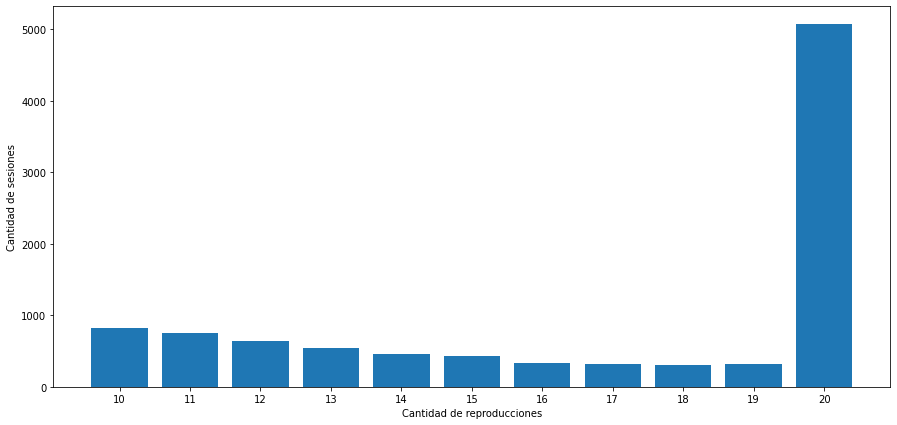

In [14]:
cantidades = sessions
cantidades.loc[:, 'cuenta_1'] = 1
cantidades.loc[:, 'cuenta_2'] = 1
cantidades = cantidades.groupby('session_id').count().groupby('cuenta_1').count()['cuenta_2']
plt.figure(figsize=(15, 7))
plt.xlabel('Cantidad de reproducciones')
plt.ylabel('Cantidad de sesiones')
plt.bar(x=np.arange(11), height=cantidades, tick_label=cantidades.index)

Cantidad de canciones con una determinada cantidad de reproducciones:

<BarContainer object of 20 artists>

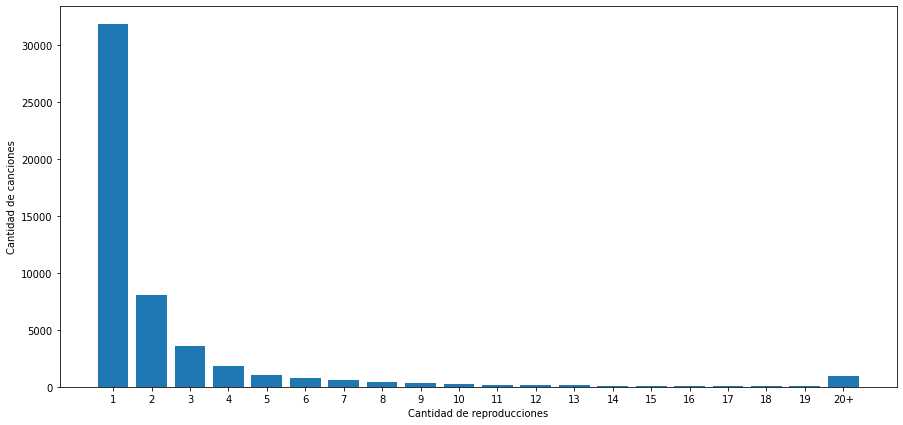

In [15]:
cantidades = sessions
cantidades.loc[:, 'cuenta_1'] = 1
cantidades.loc[:, 'cuenta_2'] = 1
cantidades = cantidades.groupby('track_id_clean').count().groupby('cuenta_1').count()[['cuenta_2']]
N = 20
N_o_mas = cantidades.loc[N:, :].sum().values[0]
cantidades = cantidades.loc[:N-1, :]
cantidades.loc[f'{N}+', 'cuenta_2'] = N_o_mas
cantidades = cantidades['cuenta_2']
plt.figure(figsize=(15, 7))
plt.xlabel('Cantidad de reproducciones')
plt.ylabel('Cantidad de canciones')
plt.bar(x=np.arange(len(cantidades)), height=cantidades, tick_label=cantidades.index)